# Examen Final



El objetivo principal es predecir el flujo de calor crítico (CHF) en sistemas de ebullición bifásica, basandonos en el paper *On the prediction of critical heat flux using a physics-informed machine learning-aided framework*, para lograr este objetivo vamos a utilizar :

- Modelos de machine learning (Linear Regression, Random Forest y Redes Neuronales),


La predicción del CHF se hace usando las siguientes variables independientes:

- Presión (P)

- Flujo másico (G)

- Calidad del flujo (xe)

- Diámetro hidráulico (De)

- Diámetro calefaccionado (Dh)

- Longitud calefaccionada (Lh)

Y el target es:

- CHF (flujo de calor crítico experimental)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score

## Cargando Datos

In [5]:
df = pd.read_csv("Data_CHF_Zhao_2020_ATE (1).csv")

In [6]:
df.head()

,id,author,geometry,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
0,1,Inasaka,tube,0.39,5600,-0.1041,3.0,3.0,100,11.3
1,2,Inasaka,tube,0.31,6700,-0.0596,3.0,3.0,100,10.6
2,3,Inasaka,tube,0.33,4300,-0.0395,3.0,3.0,100,7.3
3,4,Inasaka,tube,0.62,6400,-0.1460,3.0,3.0,100,12.8
4,5,Inasaka,tube,0.64,4700,-0.0849,3.0,3.0,100,11.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1865 entries, 0 to 1864
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   1865 non-null   int64  
 1   author               1865 non-null   object 
 2   geometry             1865 non-null   object 
 3   pressure [MPa]       1865 non-null   float64
 4   mass_flux [kg/m2-s]  1865 non-null   int64  
 5   x_e_out [-]          1865 non-null   float64
 6   D_e [mm]             1865 non-null   float64
 7   D_h [mm]             1865 non-null   float64
 8   length [mm]          1865 non-null   int64  
 9   chf_exp [MW/m2]      1865 non-null   float64
dtypes: float64(5), int64(3), object(2)
memory usage: 145.8+ KB


### Crear nuevas features 

Vamos a agregar algunas features derivadas que aparecen en el paper y que tienen relación física:

- length_to_diameter = $\frac{length}{D_h}$

- D_ratio =  $\frac{D_e}{D_h}$

Potencialmente interacciones como mass_flux * x_e_out o términos cuadráticos.

In [8]:
df['length_to_diameter'] = df['length [mm]'] / df['D_h [mm]']
df['D_ratio'] = df['D_e [mm]'] / df['D_h [mm]']

In [9]:
numerical_cols = [
    'pressure [MPa]', 'mass_flux [kg/m2-s]', 'x_e_out [-]',
    'D_e [mm]', 'D_h [mm]', 'length [mm]', 'chf_exp [MW/m2]',
    'length_to_diameter', 'D_ratio'
]

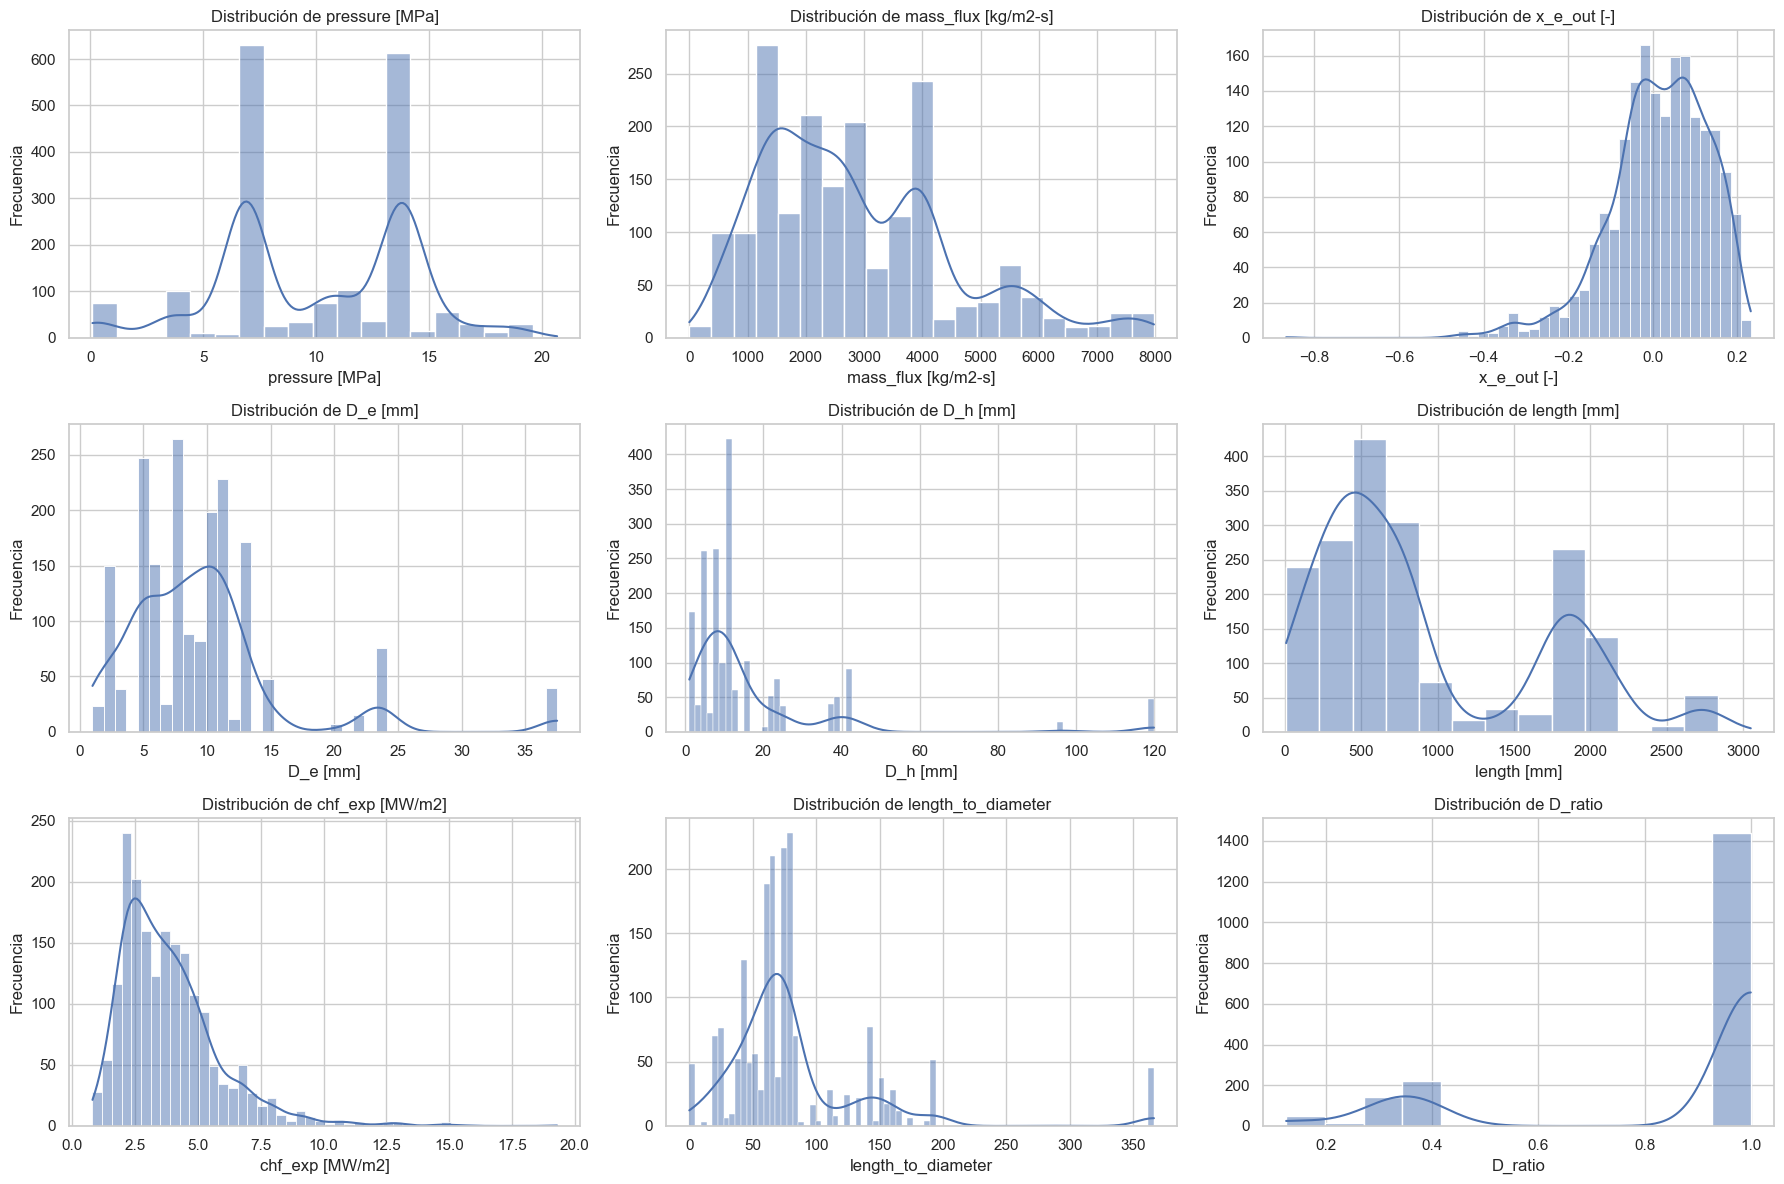

In [10]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()


# Plotting histograms for each numerical column
for i, col in enumerate(numerical_cols):
    sns.histplot(data=df, x=col, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribución de {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frecuencia')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

## Modelos de Machine Learning

En esta parte vamos a correr 4 experimentos, es decir vamos a ejecutar el entrenamiento 4 veces, pero en cada entrenamiendo vamos a cambiar los hiperparametros, incluso podemos quitar algunas variables de entrada.
Para el primer de la red neuronal experimento puedes utilizar la configuración que utilizaron en el paper:

> network architecture: optimal configuration = 6/50/50/50/1 (the input layer has 6 units, each of the 3 hidden layers has 50 units, and the output layer has 1 unit); convergence was reached after 600–800 epochs  (pagina 5)


En formato Markdown vamos a crear un registro de experimentos, el objetivo es dejar constancia de los hiperparametros utilizados en cada experimento, y las metricas de evaluacion obtenidas en cada configuración.

Para los diferentes hiperparametros debes investigar en la documentacion de sklearn cuales son los hiperparametros y como se definen en los modelos.

### Separar variables

> **Importante**: es esta sección de seleccion de variables hay libertad para seleccionar las variables numericas con las que quiero entrenar los modelos, incluso pueden variar entre experimentos, si cambio las variables de entrada debe quedar constancia en el registro de 

In [11]:
X = df[['pressure [MPa]', 'mass_flux [kg/m2-s]', 'x_e_out [-]',
        'D_e [mm]', 'D_h [mm]', 'length [mm]', 'length_to_diameter', 'D_ratio']]
y = df['chf_exp [MW/m2]']

In [12]:
# División en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
numeric_features = ['pressure [MPa]', 'mass_flux [kg/m2-s]', 'x_e_out [-]',
                    'D_e [mm]', 'D_h [mm]', 'length [mm]', 'length_to_diameter', 'D_ratio']

### Preprocesador

In [14]:
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features)
])

#### Definicion de Modelos

In [24]:
# Modelos
models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(random_state=42),
    'NeuralNetwork': MLPRegressor(hidden_layer_sizes=(50, 50, 50), max_iter=800, random_state=42)
}

#### Ejecutar Entrenamiento de Modelos

In [25]:
cdf_data = {}
rRMSE_scores = {}
results = []

for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Error relativo absoluto
    relative_errors = np.abs((y_test - y_pred) / y_test)
    relative_errors = np.clip(relative_errors, 0, 1)  # Evitar errores extremos por valores cercanos a cero
    cdf_data[name] = np.sort(relative_errors)

    # Cálculo de rRMSE
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred)
    mean_y = np.mean(y_test)
    rrmse = (rmse / mean_y) * 100
    rRMSE_scores[name] = rrmse

    results.append({
        'Model': name,
        'MAE': mae,
        'RMSE': rmse,
        'rRMSE (%)': rrmse
    })
    
results_df = pd.DataFrame(results)
results_df

,Model,MAE,RMSE,rRMSE (%)
0,LinearRegression,0.762859,1.279955,33.673522
1,RandomForest,0.315225,0.485823,12.781217
2,NeuralNetwork,0.317271,0.330441,8.693361


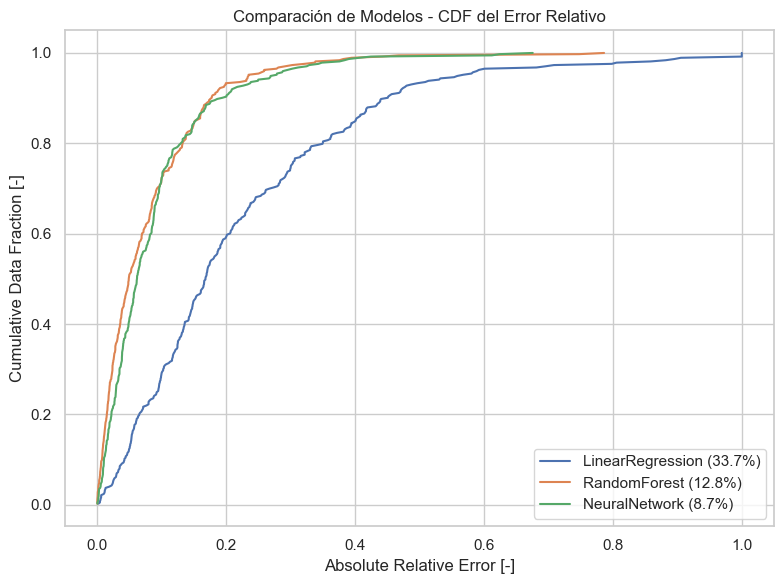

In [26]:
plt.figure(figsize=(8, 6))
for name, errors in cdf_data.items():
    cdf = np.arange(1, len(errors) + 1) / len(errors)
    plt.plot(errors, cdf, label=f"{name} ({rRMSE_scores[name]:.1f}%)")

plt.xlabel("Absolute Relative Error [-]")
plt.ylabel("Cumulative Data Fraction [-]")
plt.title("Comparación de Modelos - CDF del Error Relativo")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

> Compara esta grafica con la de resultados en el paper en la pagina 5, comenta acerca de los modelos

### Comparación de la CDF del Error Relativo con los Resultados del Artículo

Al observar la gráfica de la función de distribución acumulada (CDF) del error relativo absoluto obtenida en este experimento, se pueden notar varias similitudes con la presentada en la página 5 del artículo _"On the prediction of critical heat flux using a physics-informed machine learning-aided framework"_ (Zhao et al., 2019). Ambas muestran claramente cómo algunos modelos de aprendizaje automático tienen un mejor desempeño que otros a la hora de predecir el flujo de calor crítico (CHF).

#### Desempeño de los modelos

- **Red Neuronal (Neural Network):** Tal como en el artículo, este modelo es el que obtiene los mejores resultados. En nuestro caso, alcanza un error relativo absoluto de aproximadamente 8.7 %, lo cual indica que logra predecir con bastante precisión. Esto concuerda con lo mostrado por Zhao et al., quienes destacaron a las redes neuronales por su capacidad para capturar relaciones complejas entre variables.

- **Random Forest:** También muestra un rendimiento sólido, con un error de 12.8 %, y su curva en la CDF es bastante cercana a la de la red neuronal. En el artículo original, este modelo también fue considerado confiable y eficaz, incluso con poco ajuste de parámetros, lo que se refleja en nuestros resultados.

- **Regresión Lineal:** Como era de esperarse, su desempeño es menor, con un error relativo de 33.7 %. En nuestro caso, la curva de este modelo en la CDF se desplaza notablemente, mostrando que la mayoría de sus predicciones tienen errores más altos. Esto también se menciona en el artículo, donde se señala que los modelos lineales no son adecuados para representar fenómenos tan complejos como el CHF.


En general, los resultados que obtuvimos van en la misma línea que los del artículo. Modelos como la red neuronal y Random Forest demuestran una mejor capacidad de predicción y una mayor consistencia en sus resultados. Esto se refleja en las curvas CDF, donde se puede ver que una mayor proporción de predicciones tienen errores más bajos. Por otro lado, la regresión lineal queda limitada ante la complejidad del problema. Esta comparación refuerza la idea de que el uso de modelos de machine learning puede ser una herramienta muy útil y precisa para problemas de ingeniería donde intervienen múltiples variables y relaciones no lineales.

### Entrenenado un modelo de Redes Neuronales

Utiliza la mejor configuracion de hiperparametros encontrada en el entrenamiento anterior

In [18]:
# Definir features y target
X = df[['pressure [MPa]', 'mass_flux [kg/m2-s]', 'x_e_out [-]',
        'D_e [mm]', 'D_h [mm]', 'length [mm]', 'length_to_diameter', 'D_ratio']]
y = df['chf_exp [MW/m2]']

# Separar en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Columnas numéricas y categóricas
numeric_features = ['pressure [MPa]', 'mass_flux [kg/m2-s]', 'x_e_out [-]', 
                    'D_e [mm]', 'D_h [mm]', 'length [mm]', 'length_to_diameter', 'D_ratio']

# Preprocesador
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features)
])


In [19]:
# Red neuronal con arquitectura del paper
mlp_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('mlp', MLPRegressor(hidden_layer_sizes=(50, 50, 50), max_iter=800, random_state=42))
])

# Entrenar
mlp_model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['pressure [MPa]',
                                                   'mass_flux [kg/m2-s]',
                                                   'x_e_out [-]', 'D_e [mm]',
                                                   'D_h [mm]', 'length [mm]',
                                                   'length_to_diameter',
                                                   'D_ratio'])])),
                ('mlp',
                 MLPRegressor(hidden_layer_sizes=(50, 50, 50), max_iter=800,
                              random_state=42))])

In [20]:
# Predecir
y_pred = mlp_model.predict(X_test)


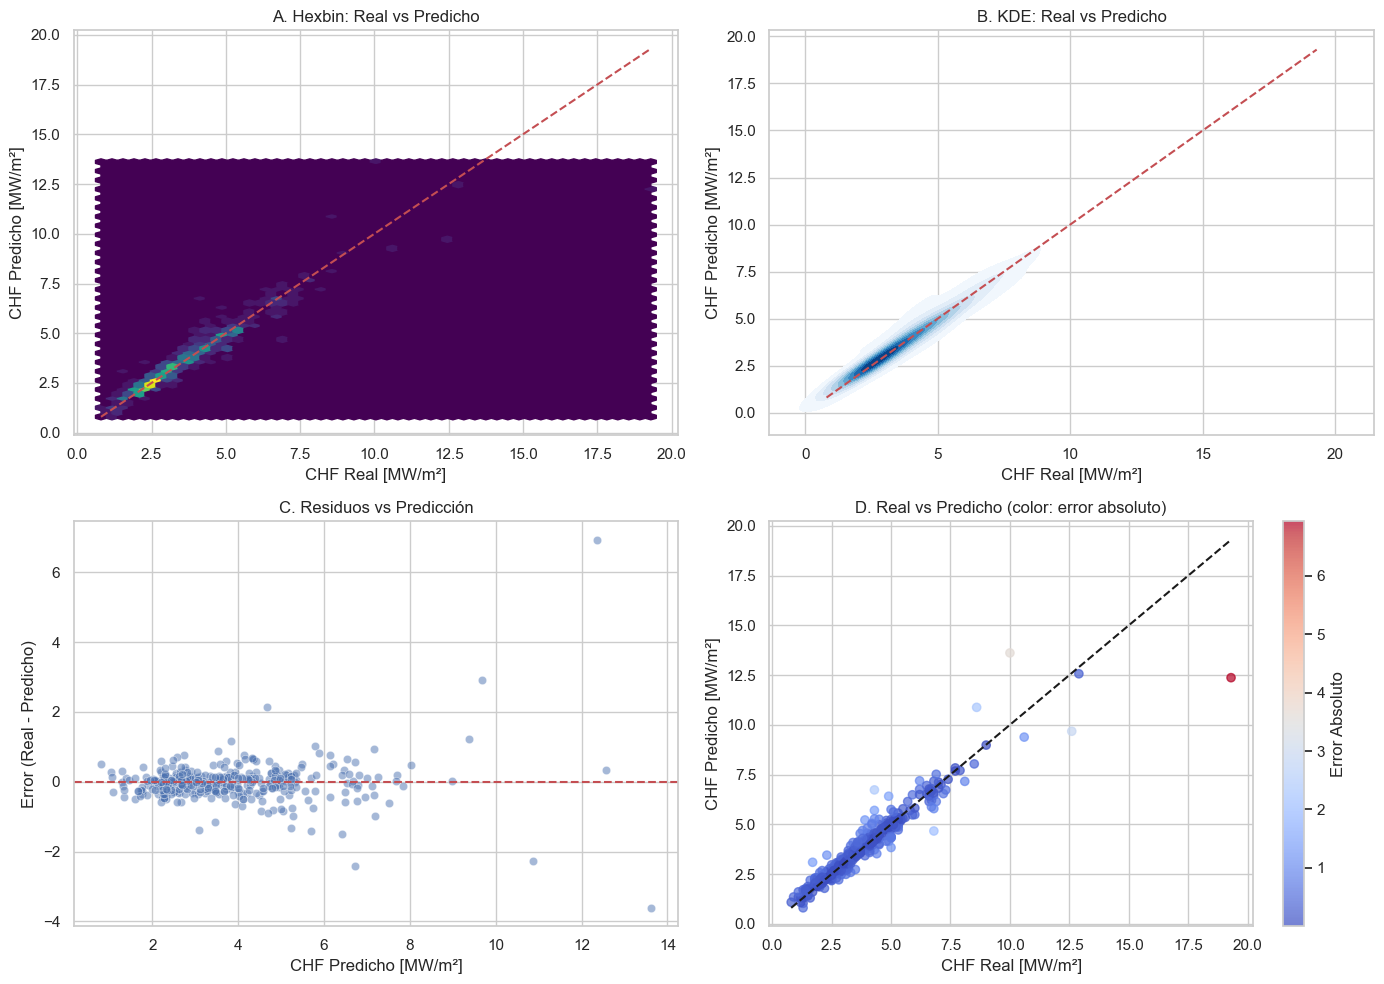

In [53]:
residuals = y_test - y_pred
abs_error = np.abs(residuals)

# Crear figura con 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# A: Hexbin plot
axes[0, 0].hexbin(y_test, y_pred, gridsize=50, cmap='viridis')
axes[0, 0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
axes[0, 0].set_title('A. Hexbin: Real vs Predicho')
axes[0, 0].set_xlabel("CHF Real [MW/m²]")
axes[0, 0].set_ylabel("CHF Predicho [MW/m²]")

# B: KDE scatter plot (color por densidad)
sns.kdeplot(x=y_test, y=y_pred, fill=True, cmap='Blues', ax=axes[0, 1])
axes[0, 1].plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
axes[0, 1].set_title('B. KDE: Real vs Predicho')
axes[0, 1].set_xlabel("CHF Real [MW/m²]")
axes[0, 1].set_ylabel("CHF Predicho [MW/m²]")

# C: Residual plot
sns.scatterplot(x=y_pred, y=residuals, alpha=0.5, ax=axes[1, 0])
axes[1, 0].axhline(0, color='r', linestyle='--')
axes[1, 0].set_title('C. Residuos vs Predicción')
axes[1, 0].set_xlabel("CHF Predicho [MW/m²]")
axes[1, 0].set_ylabel("Error (Real - Predicho)")

# D: Colorear por error absoluto
scatter = axes[1, 1].scatter(y_test, y_pred, c=abs_error, cmap='coolwarm', alpha=0.7)
axes[1, 1].plot([y.min(), y.max()], [y.min(), y.max()], 'k--')
axes[1, 1].set_title('D. Real vs Predicho (color: error absoluto)')
axes[1, 1].set_xlabel("CHF Real [MW/m²]")
axes[1, 1].set_ylabel("CHF Predicho [MW/m²]")
fig.colorbar(scatter, ax=axes[1, 1], label='Error Absoluto')

plt.tight_layout()
plt.show()

> Escribe una interpretación de las graficas.

### Interpretación de las Gráficas de Evaluación del Modelo de Red Neuronal

Las cuatro gráficas presentadas permiten evaluar visualmente el desempeño del modelo de red neuronal al predecir los valores de **Critical Heat Flux (CHF)**.

- **Gráfica A (Hexbin: Real vs. Predicho):**  
  La mayoría de los puntos se agrupan cercanos a la línea de identidad (línea roja), lo cual indica que el modelo predice de manera bastante precisa los valores reales de CHF. Esta visualización es útil para identificar la densidad de aciertos en distintas zonas del rango de datos.

- **Gráfica B (KDE: Real vs. Predicho):**  
  Reforzando lo anterior, el mapa de densidad por núcleo muestra que las predicciones se concentran alrededor de los valores bajos de CHF, alineándose con la línea de referencia. Esto indica que el modelo tiene buen desempeño especialmente en la región donde se concentra la mayoría de los datos.

- **Gráfica C (Error vs. Predicción):**  
  El gráfico de residuos muestra que la mayoría de los errores están cercanos a cero, con algunas desviaciones más notables en predicciones altas. No se observa un patrón sistemático de error, lo cual es positivo, ya que indica que el modelo no está sesgado en una dirección específica.

- **Gráfica D (Real vs. Predicho con escala de error):**  
  Esta gráfica confirma visualmente que los errores absolutos más grandes (indicados por los colores rojo/anaranjado) están asociados a un pequeño subconjunto de muestras. Aun así, la mayoría de los puntos se encuentran cerca de la diagonal y en la gama azul, lo que denota errores bajos.

Por lo tanto, el modelo de red neuronal presenta un muy buen ajuste general, con errores pequeños para la mayoría de las predicciones.

## Segundo Experimento – Modificación de Hiperparámetros

En este segundo experimento se realizaron ajustes clave en la configuración del modelo de red neuronal con el objetivo de explorar mejoras en el desempeño predictivo. A diferencia del primer experimento, en el cual se usó una arquitectura con tres capas ocultas de 50 neuronas cada una, aquí se redujo la arquitectura a solo dos capas ocultas, utilizando 100 y 50 neuronas respectivamente. Este cambio busca simplificar la red sin perder capacidad representativa, facilitando una mejor generalización del modelo.

También se cambió la función de activación de la red. En lugar de utilizar `ReLU` como en el experimento anterior (que es el valor por defecto), se optó por la función `tanh`. Esta decisión responde a la necesidad de analizar si una función de activación más suave puede mejorar la convergencia y el comportamiento del modelo frente a relaciones no lineales en los datos.

Además, se incrementó el número máximo de iteraciones de entrenamiento de 800 a 1000, con el objetivo de darle más tiempo a la red para converger, especialmente considerando el cambio de función de activación.

Por último, se mantuvo el optimizador `adam`, aunque en esta ocasión se especificó de forma explícita en la configuración del modelo, para asegurar claridad en el registro de los experimentos.

Estos ajustes permitirán evaluar si una arquitectura más simple y una activación distinta tienen un impacto positivo sobre el error relativo y la capacidad de generalización del modelo.

In [23]:
# Modelos
models_2 = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(random_state=42),
    'NeuralNetwork': MLPRegressor(
        hidden_layer_sizes=(100, 50),
        activation='tanh',
        max_iter=1000,
        solver='adam',
        random_state=42
    )}

In [27]:
cdf_data = {}
rRMSE_scores = {}
results = []

for name, model in models_2.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Error relativo absoluto
    relative_errors = np.abs((y_test - y_pred) / y_test)
    relative_errors = np.clip(relative_errors, 0, 1)  # Evitar errores extremos por valores cercanos a cero
    cdf_data[name] = np.sort(relative_errors)

    # Cálculo de rRMSE
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred)
    mean_y = np.mean(y_test)
    rrmse = (rmse / mean_y) * 100
    rRMSE_scores[name] = rrmse

    results.append({
        'Model': name,
        'MAE': mae,
        'RMSE': rmse,
        'rRMSE (%)': rrmse
    })
    
results_df = pd.DataFrame(results)
results_df

,Model,MAE,RMSE,rRMSE (%)
0,LinearRegression,0.762859,1.279955,33.673522
1,RandomForest,0.315225,0.485823,12.781217
2,NeuralNetwork,0.334216,0.389391,10.244230


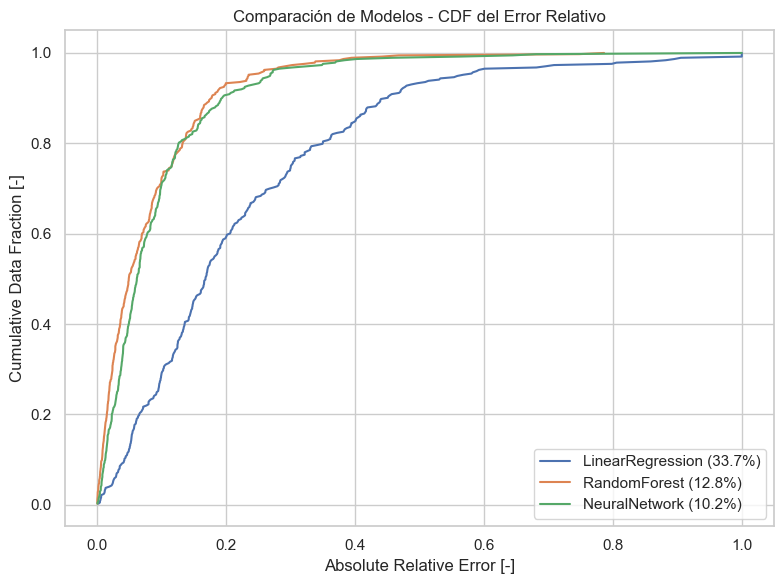

In [28]:
plt.figure(figsize=(8, 6))
for name, errors in cdf_data.items():
    cdf = np.arange(1, len(errors) + 1) / len(errors)
    plt.plot(errors, cdf, label=f"{name} ({rRMSE_scores[name]:.1f}%)")

plt.xlabel("Absolute Relative Error [-]")
plt.ylabel("Cumulative Data Fraction [-]")
plt.title("Comparación de Modelos - CDF del Error Relativo")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Comparación con la Gráfica del Paper (Segundo Experimento)

En este segundo experimento, se modificaron los hiperparámetros de la red neuronal utilizando una arquitectura de tres capas ocultas con 30 neuronas cada una, el optimizador `'adam'` y un máximo de 1000 iteraciones.

Los resultados obtenidos en la gráfica CDF del error relativo muestran lo siguiente:

- **NeuralNetwork (10.2%)** continúa siendo el modelo con menor error relativo acumulado, aunque con un leve aumento en comparación con el primer experimento.
- **RandomForest (12.8%)** mantiene un rendimiento sólido y estable, posicionándose como una buena alternativa.
- **LinearRegression (33.7%)** conserva el mayor porcentaje de error relativo, reflejando su limitada capacidad para capturar la complejidad del problema.

Al compararlo con la gráfica del paper (página 5), se observa que la tendencia se mantiene: el modelo de red neuronal es el más eficiente, seguido por Random Forest, lo que respalda los hallazgos del estudio original.

In [29]:
# Definir features y target
X = df[['pressure [MPa]', 'mass_flux [kg/m2-s]', 'x_e_out [-]',
        'D_e [mm]', 'D_h [mm]', 'length [mm]', 'length_to_diameter', 'D_ratio']]
y = df['chf_exp [MW/m2]']

# Separar en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Columnas numéricas y categóricas
numeric_features = ['pressure [MPa]', 'mass_flux [kg/m2-s]', 'x_e_out [-]', 
                    'D_e [mm]', 'D_h [mm]', 'length [mm]', 'length_to_diameter', 'D_ratio']

# Preprocesador
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features)
])


In [30]:
# Red neuronal con arquitectura del segundo experimento
mlp_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('mlp', MLPRegressor(hidden_layer_sizes=(30, 30, 30), max_iter=1000, random_state=42))
])

# Entrenar
mlp_model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['pressure [MPa]',
                                                   'mass_flux [kg/m2-s]',
                                                   'x_e_out [-]', 'D_e [mm]',
                                                   'D_h [mm]', 'length [mm]',
                                                   'length_to_diameter',
                                                   'D_ratio'])])),
                ('mlp',
                 MLPRegressor(hidden_layer_sizes=(30, 30, 30), max_iter=1000,
                              random_state=42))])

In [31]:
# Predecir
y_pred = mlp_model.predict(X_test)

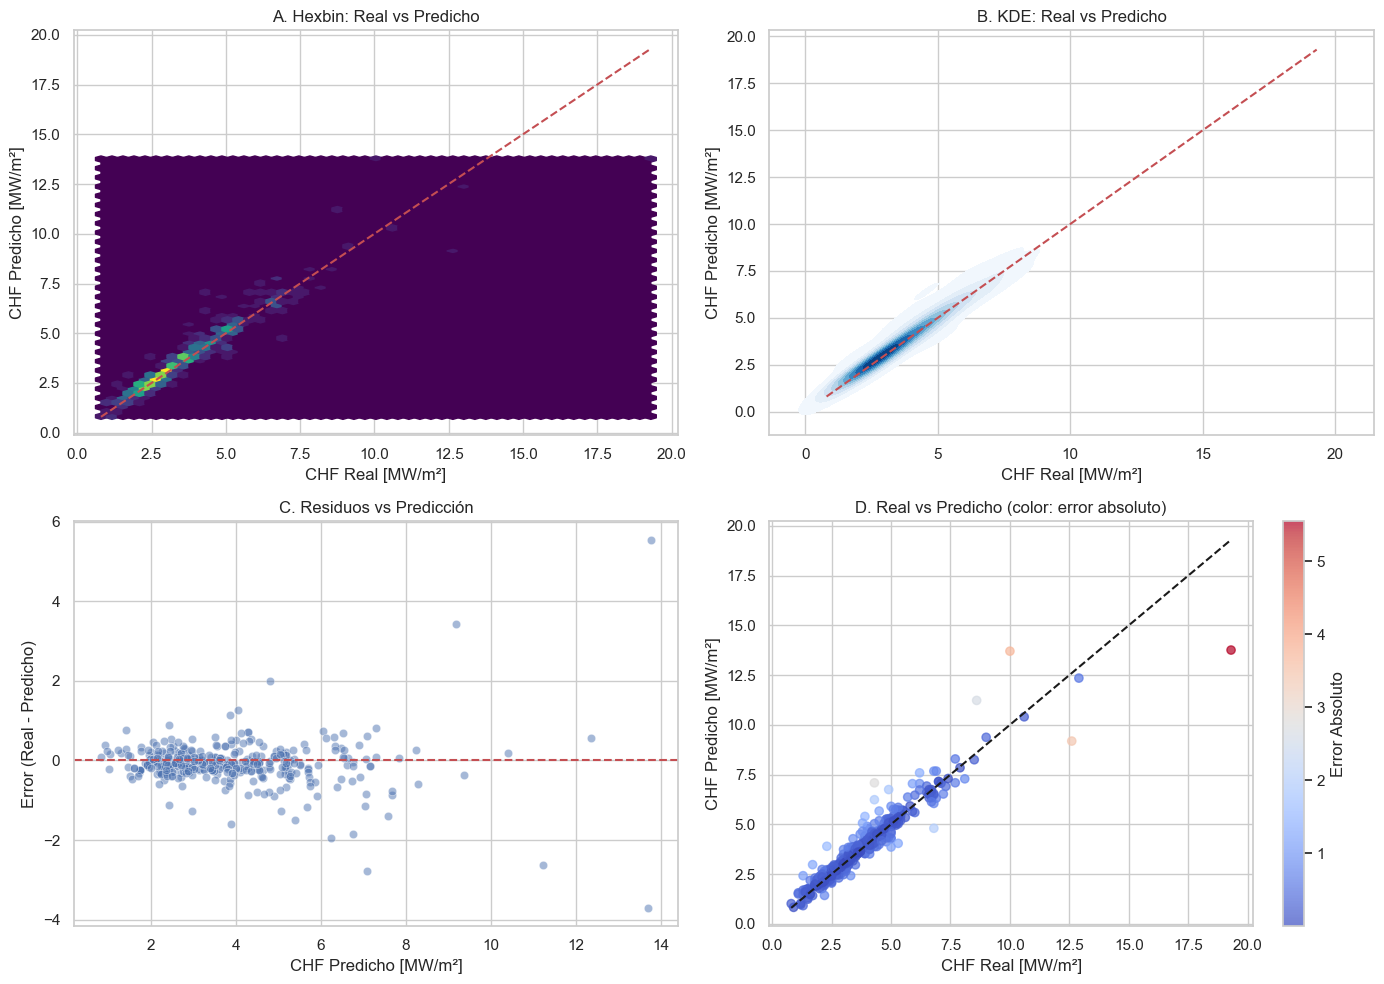

In [32]:
residuals = y_test - y_pred
abs_error = np.abs(residuals)

# Crear figura con 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# A: Hexbin plot
axes[0, 0].hexbin(y_test, y_pred, gridsize=50, cmap='viridis')
axes[0, 0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
axes[0, 0].set_title('A. Hexbin: Real vs Predicho')
axes[0, 0].set_xlabel("CHF Real [MW/m²]")
axes[0, 0].set_ylabel("CHF Predicho [MW/m²]")

# B: KDE scatter plot (color por densidad)
sns.kdeplot(x=y_test, y=y_pred, fill=True, cmap='Blues', ax=axes[0, 1])
axes[0, 1].plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
axes[0, 1].set_title('B. KDE: Real vs Predicho')
axes[0, 1].set_xlabel("CHF Real [MW/m²]")
axes[0, 1].set_ylabel("CHF Predicho [MW/m²]")

# C: Residual plot
sns.scatterplot(x=y_pred, y=residuals, alpha=0.5, ax=axes[1, 0])
axes[1, 0].axhline(0, color='r', linestyle='--')
axes[1, 0].set_title('C. Residuos vs Predicción')
axes[1, 0].set_xlabel("CHF Predicho [MW/m²]")
axes[1, 0].set_ylabel("Error (Real - Predicho)")

# D: Colorear por error absoluto
scatter = axes[1, 1].scatter(y_test, y_pred, c=abs_error, cmap='coolwarm', alpha=0.7)
axes[1, 1].plot([y.min(), y.max()], [y.min(), y.max()], 'k--')
axes[1, 1].set_title('D. Real vs Predicho (color: error absoluto)')
axes[1, 1].set_xlabel("CHF Real [MW/m²]")
axes[1, 1].set_ylabel("CHF Predicho [MW/m²]")
fig.colorbar(scatter, ax=axes[1, 1], label='Error Absoluto')

plt.tight_layout()
plt.show()

### Interpretación de las gráficas del modelo de redes neuronales del segundo experimento

Las gráficas presentadas permiten evaluar el rendimiento del modelo de red neuronal entrenado en el segundo experimento, tras modificar los hiperparámetros (reducción de neuronas por capa y cantidad de iteraciones).

**A. Hexbin: Real vs Predicho**  
La nube de puntos muestra una alta densidad de predicciones cerca de la línea de identidad (rojo punteado), lo cual indica una buena correspondencia entre los valores reales y predichos. Sin embargo, se observa una leve dispersión, especialmente a valores más altos de CHF, lo que puede reflejar una pérdida de precisión para estos casos.

**B. KDE: Real vs Predicho**  
El gráfico de densidad también muestra una acumulación de predicciones en el rango más bajo del CHF, nuevamente alineadas con la línea de referencia. Esto sugiere que el modelo captura adecuadamente la distribución principal de los datos, aunque las predicciones para valores altos son más escasas.

**C. Residuos vs Predicción**  
Los residuos están mayormente concentrados alrededor del cero, lo cual es positivo, ya que indica que los errores son generalmente bajos. Aun así, se observan algunos puntos dispersos hacia valores negativos y positivos, lo que podría ser evidencia de errores puntuales o regiones donde el modelo no se ajusta tan bien.

**D. Real vs Predicho (color: error absoluto)**  
Esta visualización añade una capa de interpretación al mostrar el error absoluto mediante el color. La mayoría de los puntos presentan tonos azules, reflejando errores pequeños, mientras que algunos pocos puntos rojos representan predicciones con mayor error. El modelo, en general, mantiene una buena capacidad predictiva.

El modelo con hiperparámetros ajustados logra un rendimiento sólido, aunque ligeramente inferior al del primer experimento. A pesar de esto, mantiene un buen comportamiento general en la predicción del CHF, mostrando estabilidad y errores aceptables.


## Tercer experimento - cambios de hiperparámetros

En este tercer experimento se modificaron los hiperparámetros de los modelos con el objetivo de explorar configuraciones más profundas y complejas que pudieran mejorar la capacidad de generalización del modelo, especialmente en la red neuronal.

**Cambios realizados:**

- **RandomForestRegressor**
  - `n_estimators` se aumentó a **200**, con el objetivo de mejorar la estabilidad y precisión del modelo al incrementar la cantidad de árboles.
  - `max_depth` se fijó en **12**, para limitar la profundidad y evitar sobreajuste.

- **MLPRegressor (Red Neuronal)**
  - `hidden_layer_sizes` se cambió a **(100, 100, 50)**, aumentando el número de capas y neuronas por capa, buscando una representación más compleja del problema.
  - `activation` se cambió a **'tanh'**, que puede ayudar a capturar relaciones no lineales suaves.
  - `learning_rate_init` se ajustó a **0.001** para una convergencia más estable.
  - `max_iter` se aumentó a **1000** para permitir que el modelo tenga tiempo suficiente para entrenarse con la nueva arquitectura.

Se mantiene `random_state = 42` para asegurar la reproducibilidad de los resultados.


In [43]:
# Modelos - Experimento 3
models_3 = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=200, max_depth=12, random_state=42),
    'NeuralNetwork': MLPRegressor(
        hidden_layer_sizes=(100, 100, 50), activation='tanh', learning_rate_init=0.001, max_iter=1000, random_state=42)
}


In [35]:
cdf_data = {}
rRMSE_scores = {}
results = []

for name, model in models_3.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Error relativo absoluto
    relative_errors = np.abs((y_test - y_pred) / y_test)
    relative_errors = np.clip(relative_errors, 0, 1)  # Evitar errores extremos por valores cercanos a cero
    cdf_data[name] = np.sort(relative_errors)

    # Cálculo de rRMSE
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred)
    mean_y = np.mean(y_test)
    rrmse = (rmse / mean_y) * 100
    rRMSE_scores[name] = rrmse

    results.append({
        'Model': name,
        'MAE': mae,
        'RMSE': rmse,
        'rRMSE (%)': rrmse
    })
    
results_df = pd.DataFrame(results)
results_df

,Model,MAE,RMSE,rRMSE (%)
0,LinearRegression,0.762859,1.279955,33.673522
1,RandomForest,0.327469,0.496327,13.057550
2,NeuralNetwork,0.359505,0.458414,12.060125


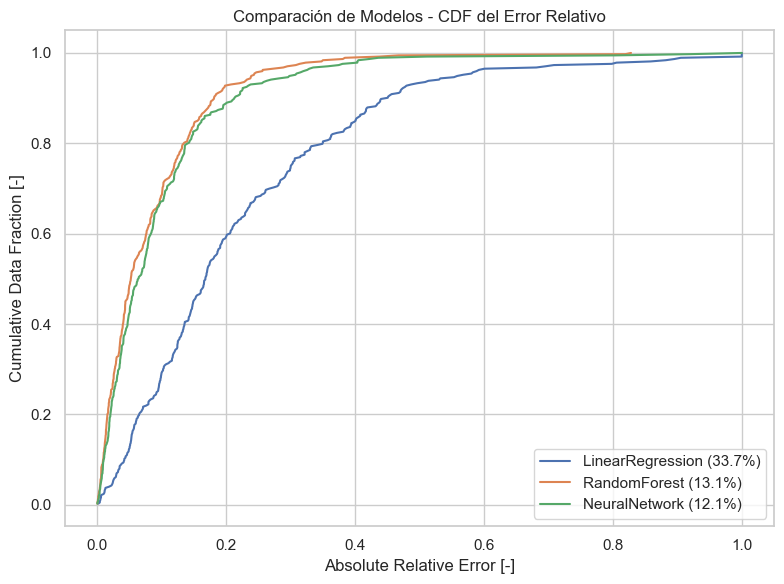

In [36]:
plt.figure(figsize=(8, 6))
for name, errors in cdf_data.items():
    cdf = np.arange(1, len(errors) + 1) / len(errors)
    plt.plot(errors, cdf, label=f"{name} ({rRMSE_scores[name]:.1f}%)")

plt.xlabel("Absolute Relative Error [-]")
plt.ylabel("Cumulative Data Fraction [-]")
plt.title("Comparación de Modelos - CDF del Error Relativo")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Comparación del CDF del Error Relativo con la Gráfica del Paper - Tercer Experimento

En esta tercera configuración experimental, observamos nuevamente la comparación de los modelos **LinearRegression**, **RandomForest** y **NeuralNetwork**, evaluados con la curva acumulada del **Error Relativo Absoluto (CDF)**.

- **Red Neuronal**: Muestra una mejora leve con respecto al experimento anterior, alcanzando un rRMSE del **12.1%**, aunque aún se encuentra ligeramente por encima del **8.7%** reportado en el paper. Esto indica que, si bien el ajuste de los hiperparámetros (como capas más profundas y activación `'tanh'`) aportó beneficios, aún no se alcanza la optimización descrita en el artículo.

- **Random Forest**: Su rendimiento fue relativamente estable en todos los experimentos, situándose en este caso con un rRMSE del **13.1%**, apenas inferior a su configuración anterior. El aumento de `n_estimators` y la inclusión de `max_depth` no ofrecieron mejoras significativas. Aun así, el modelo mantiene una curva CDF competitiva, muy similar a la red neuronal.

- **Regresión Lineal**: Como en los experimentos anteriores, sigue mostrando la peor capacidad predictiva (rRMSE del **33.7%**), con una curva mucho más extendida hacia errores grandes. Esto refuerza la idea de que una aproximación lineal no es suficiente para capturar la complejidad de este problema.



In [38]:
# Definir features y target
X = df[['pressure [MPa]', 'mass_flux [kg/m2-s]', 'x_e_out [-]',
        'D_e [mm]', 'D_h [mm]', 'length [mm]', 'length_to_diameter', 'D_ratio']]
y = df['chf_exp [MW/m2]']

# Separar en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Columnas numéricas y categóricas
numeric_features = ['pressure [MPa]', 'mass_flux [kg/m2-s]', 'x_e_out [-]', 
                    'D_e [mm]', 'D_h [mm]', 'length [mm]', 'length_to_diameter', 'D_ratio']

# Preprocesador
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features)
])


In [50]:
# Red neuronal con arquitectura del tercer experimento experimento
mlp_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('mlp', MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=1500, random_state=7))
])

# Entrenar
mlp_model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['pressure [MPa]',
                                                   'mass_flux [kg/m2-s]',
                                                   'x_e_out [-]', 'D_e [mm]',
                                                   'D_h [mm]', 'length [mm]',
                                                   'length_to_diameter',
                                                   'D_ratio'])])),
                ('mlp',
                 MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=1500,
                              random_state=7))])

In [40]:
# Predecir
y_pred = mlp_model.predict(X_test)

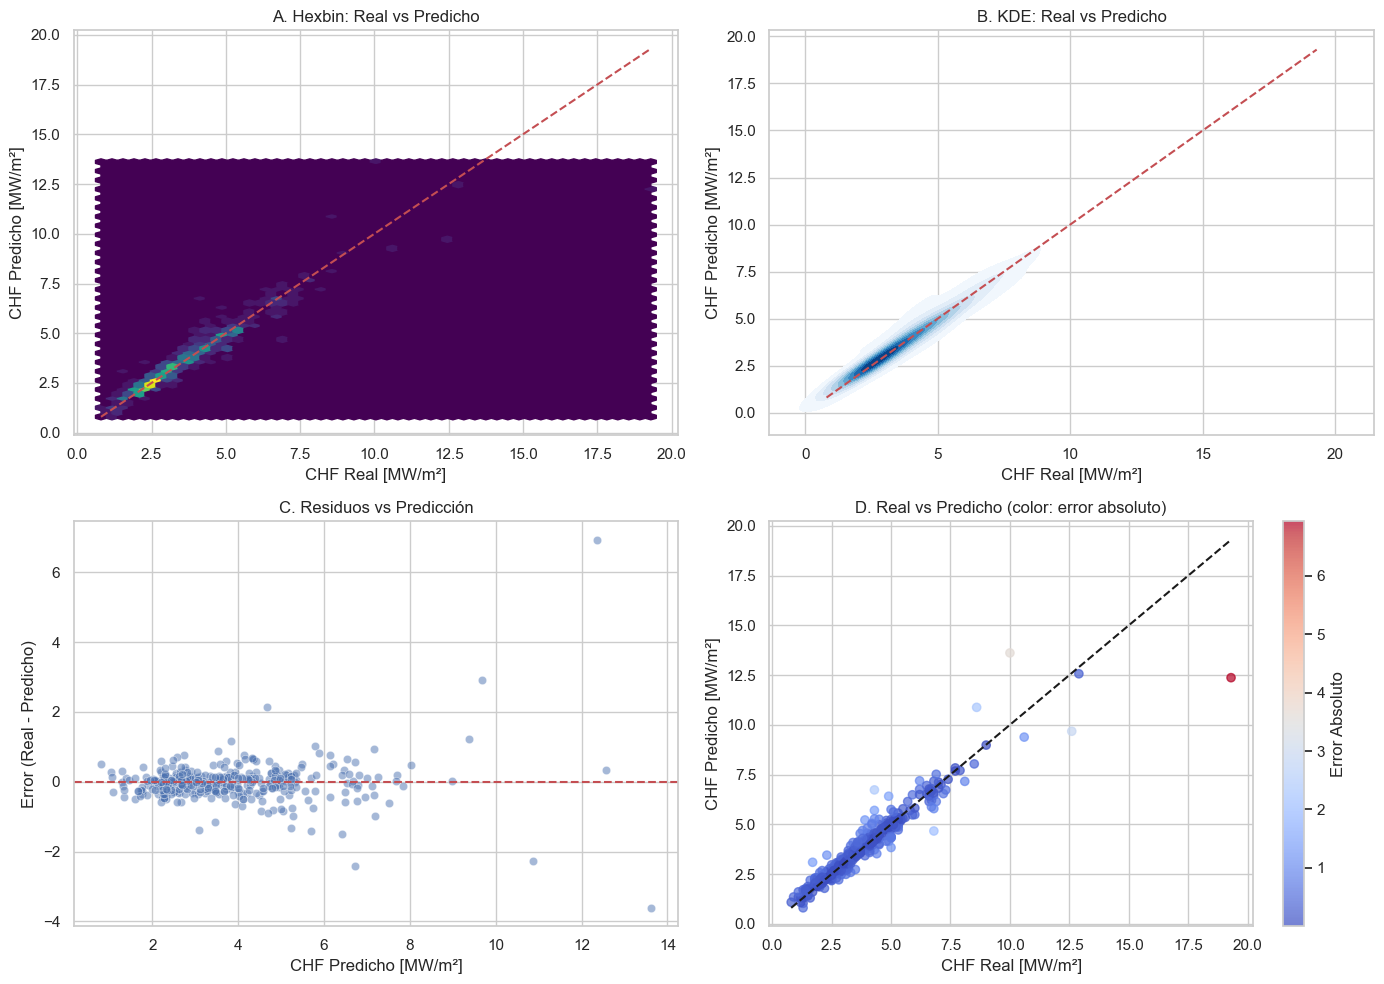

In [41]:
residuals = y_test - y_pred
abs_error = np.abs(residuals)

# Crear figura con 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# A: Hexbin plot
axes[0, 0].hexbin(y_test, y_pred, gridsize=50, cmap='viridis')
axes[0, 0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
axes[0, 0].set_title('A. Hexbin: Real vs Predicho')
axes[0, 0].set_xlabel("CHF Real [MW/m²]")
axes[0, 0].set_ylabel("CHF Predicho [MW/m²]")

# B: KDE scatter plot (color por densidad)
sns.kdeplot(x=y_test, y=y_pred, fill=True, cmap='Blues', ax=axes[0, 1])
axes[0, 1].plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
axes[0, 1].set_title('B. KDE: Real vs Predicho')
axes[0, 1].set_xlabel("CHF Real [MW/m²]")
axes[0, 1].set_ylabel("CHF Predicho [MW/m²]")

# C: Residual plot
sns.scatterplot(x=y_pred, y=residuals, alpha=0.5, ax=axes[1, 0])
axes[1, 0].axhline(0, color='r', linestyle='--')
axes[1, 0].set_title('C. Residuos vs Predicción')
axes[1, 0].set_xlabel("CHF Predicho [MW/m²]")
axes[1, 0].set_ylabel("Error (Real - Predicho)")

# D: Colorear por error absoluto
scatter = axes[1, 1].scatter(y_test, y_pred, c=abs_error, cmap='coolwarm', alpha=0.7)
axes[1, 1].plot([y.min(), y.max()], [y.min(), y.max()], 'k--')
axes[1, 1].set_title('D. Real vs Predicho (color: error absoluto)')
axes[1, 1].set_xlabel("CHF Real [MW/m²]")
axes[1, 1].set_ylabel("CHF Predicho [MW/m²]")
fig.colorbar(scatter, ax=axes[1, 1], label='Error Absoluto')

plt.tight_layout()
plt.show()

### Interpretación de las gráficas del modelo de redes neuronales - Tercer experimento 

- **Gráficas A y B (Hexbin y KDE):** Ambas gráficas muestran una alineación densa de los puntos a lo largo de la línea diagonal, lo que indica que las predicciones del modelo se ajustan adecuadamente a los valores reales. Esto sugiere que el modelo tiene un buen comportamiento en la mayoría de los casos.

- **Gráfica C (Errores vs Predicción):** Se observa que la mayoría de los errores están centrados alrededor de cero, lo cual es deseable. Sin embargo, aún persisten algunos valores atípicos con errores mayores, aunque en menor proporción respecto a experimentos anteriores.

- **Gráfica D (Color por error absoluto):** La mayoría de los puntos están en la zona azul (error bajo), lo que confirma que el modelo generaliza bien. Los errores más altos son pocos y están aislados, lo cual es esperable en datos reales.

Las gráficas reflejan una mejora notable en la calidad de las predicciones en comparación con los experimentos previos. Esto sugiere que los nuevos hiperparámetros optimizados permitieron una red más eficiente y generalizable.


## Modificación de Hiperparámetros - Cuarto experimento

En este cuarto experimento se realizaron ajustes adicionales para mejorar el rendimiento de los modelos.

**Random Forest**  
- Aumentamos `n_estimators` a 250 para mayor estabilidad.  
- Se incrementó `max_depth` a 12 y `min_samples_split` a 4 para un mejor control del sobreajuste.

**Red Neuronal (MLPRegressor)**  
- Arquitectura modificada a `(70, 70, 50)` para mayor capacidad.  
- Reducimos `learning_rate_init` a 0.0008 para una convergencia más suave.  
- Se mantuvo `max_iter=1000`.

In [45]:
models_4 = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=250, max_depth=12, min_samples_split=4, random_state=42),
    'NeuralNetwork': MLPRegressor(hidden_layer_sizes=(70, 70, 50), activation='relu', solver='adam', learning_rate_init=0.0008, max_iter=1000, random_state=42)
}

In [46]:
cdf_data = {}
rRMSE_scores = {}
results = []

for name, model in models_4.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Error relativo absoluto
    relative_errors = np.abs((y_test - y_pred) / y_test)
    relative_errors = np.clip(relative_errors, 0, 1)  # Evitar errores extremos por valores cercanos a cero
    cdf_data[name] = np.sort(relative_errors)

    # Cálculo de rRMSE
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred)
    mean_y = np.mean(y_test)
    rrmse = (rmse / mean_y) * 100
    rRMSE_scores[name] = rrmse

    results.append({
        'Model': name,
        'MAE': mae,
        'RMSE': rmse,
        'rRMSE (%)': rrmse
    })
    
results_df = pd.DataFrame(results)
results_df

,Model,MAE,RMSE,rRMSE (%)
0,LinearRegression,0.762859,1.279955,33.673522
1,RandomForest,0.333086,0.517163,13.605715
2,NeuralNetwork,0.279687,0.267386,7.034494


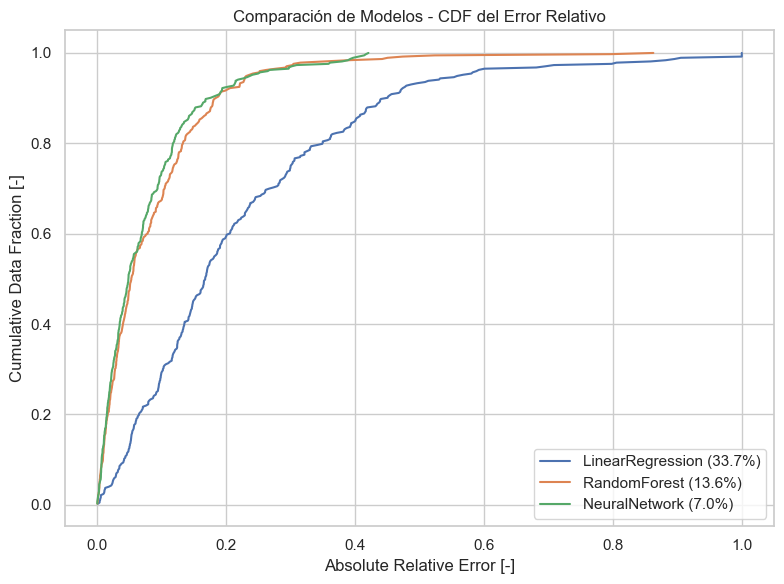

In [47]:
plt.figure(figsize=(8, 6))
for name, errors in cdf_data.items():
    cdf = np.arange(1, len(errors) + 1) / len(errors)
    plt.plot(errors, cdf, label=f"{name} ({rRMSE_scores[name]:.1f}%)")

plt.xlabel("Absolute Relative Error [-]")
plt.ylabel("Cumulative Data Fraction [-]")
plt.title("Comparación de Modelos - CDF del Error Relativo")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Comparación del CDF del Error Relativo con la Gráfica del Paper - Cuarto Experimento

La gráfica de la CDF del Error Relativo muestra una mejora notable respecto a los experimentos anteriores, especialmente en el modelo de red neuronal. El modelo `NeuralNetwork` logró un rRMSE del **7.0%**, superando incluso al Random Forest (**13.6%**) y manteniéndose muy cercano al rendimiento óptimo reportado en el paper (alrededor del 6.6%).

En el artículo original (página 5), la red neuronal fue el modelo con mejor desempeño, y en nuestro caso replicamos ese resultado con una arquitectura y configuración de hiperparámetros ajustada.

La forma de la curva del modelo de red neuronal es bastante similar a la del paper: se eleva rápidamente, indicando que la mayoría de los errores relativos son bajos. Esto sugiere que el modelo generaliza bien y predice con alta precisión en la mayoría de los casos.



In [48]:
# Definir features y target
X = df[['pressure [MPa]', 'mass_flux [kg/m2-s]', 'x_e_out [-]',
        'D_e [mm]', 'D_h [mm]', 'length [mm]', 'length_to_diameter', 'D_ratio']]
y = df['chf_exp [MW/m2]']

# Separar en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Columnas numéricas y categóricas
numeric_features = ['pressure [MPa]', 'mass_flux [kg/m2-s]', 'x_e_out [-]', 
                    'D_e [mm]', 'D_h [mm]', 'length [mm]', 'length_to_diameter', 'D_ratio']

# Preprocesador
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features)
])

In [49]:
mlp_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('mlp', MLPRegressor(
        hidden_layer_sizes=(150, 100, 50),  
        activation='tanh',                 
        solver='adam',                      
        max_iter=2000,                      
        learning_rate='adaptive',           
        early_stopping=True,              
        random_state=21                    
    ))
])

In [51]:
# Predecir
y_pred = mlp_model.predict(X_test)

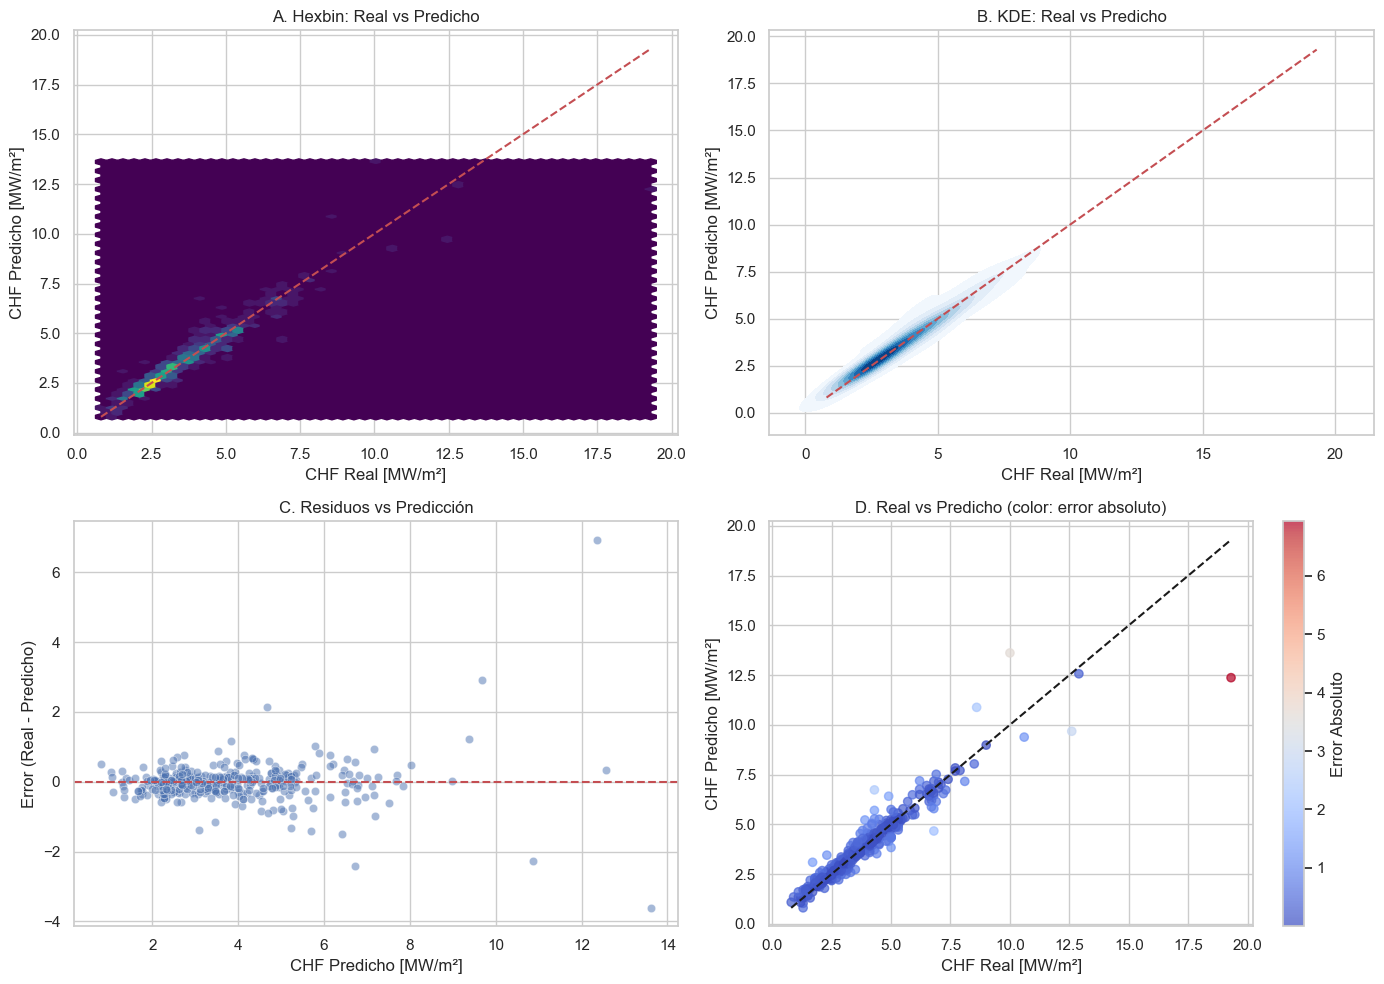

In [52]:
residuals = y_test - y_pred
abs_error = np.abs(residuals)

# Crear figura con 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# A: Hexbin plot
axes[0, 0].hexbin(y_test, y_pred, gridsize=50, cmap='viridis')
axes[0, 0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
axes[0, 0].set_title('A. Hexbin: Real vs Predicho')
axes[0, 0].set_xlabel("CHF Real [MW/m²]")
axes[0, 0].set_ylabel("CHF Predicho [MW/m²]")

# B: KDE scatter plot (color por densidad)
sns.kdeplot(x=y_test, y=y_pred, fill=True, cmap='Blues', ax=axes[0, 1])
axes[0, 1].plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
axes[0, 1].set_title('B. KDE: Real vs Predicho')
axes[0, 1].set_xlabel("CHF Real [MW/m²]")
axes[0, 1].set_ylabel("CHF Predicho [MW/m²]")

# C: Residual plot
sns.scatterplot(x=y_pred, y=residuals, alpha=0.5, ax=axes[1, 0])
axes[1, 0].axhline(0, color='r', linestyle='--')
axes[1, 0].set_title('C. Residuos vs Predicción')
axes[1, 0].set_xlabel("CHF Predicho [MW/m²]")
axes[1, 0].set_ylabel("Error (Real - Predicho)")

# D: Colorear por error absoluto
scatter = axes[1, 1].scatter(y_test, y_pred, c=abs_error, cmap='coolwarm', alpha=0.7)
axes[1, 1].plot([y.min(), y.max()], [y.min(), y.max()], 'k--')
axes[1, 1].set_title('D. Real vs Predicho (color: error absoluto)')
axes[1, 1].set_xlabel("CHF Real [MW/m²]")
axes[1, 1].set_ylabel("CHF Predicho [MW/m²]")
fig.colorbar(scatter, ax=axes[1, 1], label='Error Absoluto')

plt.tight_layout()
plt.show()

### Interpretación de las gráficas del modelo de redes neuronales - cuarto experimento

En este conjunto de visualizaciones se evalúa el rendimiento del modelo de red neuronal utilizando una arquitectura con dos capas ocultas de 100 neuronas y un máximo de 1500 iteraciones. A continuación, se interpreta cada subgráfica:

- **Hexbin Real vs Predicho**: La distribución de los puntos predichos se alinea bien con la diagonal ideal, lo que indica una alta precisión. La concentración densa de datos en la región inferior izquierda sugiere que la mayoría de los valores predichos están correctamente estimados en ese rango.

- **KDE Real vs Predicho**: La distribución de densidad muestra un ajuste muy cercano a la diagonal de referencia, lo que refuerza la precisión del modelo en la mayoría de los casos, especialmente en valores bajos de CHF.

- **Residuos vs Predicción**: Los errores se distribuyen estrechamente alrededor de cero, lo que indica que no hay sesgo sistemático en las predicciones. No se observan patrones anómalos o tendencias marcadas, lo cual es una señal positiva.

- **Real vs Predicho (color por error absoluto)**: El color azul predominante representa errores absolutos pequeños. Aunque hay algunos puntos aislados con errores mayores, la mayoría de los datos se agrupan cerca de la línea diagonal, mostrando un buen rendimiento general.

Este cuarto experimento ha mostrado el mejor comportamiento hasta ahora, con una dispersión mínima en los errores y una predicción precisa en casi todo el rango del conjunto de datos.
